### https://www.kaggle.com/competitions/dogs-vs-cats/data

In [ ]:
!pip install torchsummary
!pip install tqdm

## import

In [ ]:
path = "/content/drive/MyDrive/02.Project/Bit_PoscoDX"

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL
import shutil
import zipfile
import glob
import os
import time

## Dataset 준비

In [ ]:
import os
import zipfile

data_zip_dir = path + "/Dataset"
data_dir = path + "/Data"

# 압축 풀기
train_zip_dir = os.path.join(data_zip_dir, 'train.zip')
test_zip_dir = os.path.join(data_zip_dir, 'test1.zip')

with zipfile.ZipFile(train_zip_dir, 'r') as z:
    z.extractall()
with zipfile.ZipFile(test_zip_dir, 'r') as z:
    z.extractall()

In [ ]:
train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')

train_set_dir = os.path.join(train_dir, 'train')
os.mkdir(train_set_dir)
valid_set_dir = os.path.join(train_dir, 'valid')
os.mkdir(valid_set_dir)
test_set_dir = os.path.join(train_dir, 'test')
os.mkdir(test_set_dir)

dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

In [ ]:
for dog, cat in zip(dog_files[:10000], cat_files[:10000]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(train_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(train_set_dir, cat)
    shutil.move(src, dst)

for dog, cat in zip(dog_files[10000:11250], cat_files[10000:11250]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(valid_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(valid_set_dir, cat)
    shutil.move(src, dst)

for dog, cat in zip(dog_files[11250:12500], cat_files[11250:12500]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(test_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(test_set_dir, cat)
    shutil.move(src, dst)

In [ ]:
# import shutil
# import os

# source_dir = '/content/train'
# destination_dir = '/content/drive/MyDrive/02.Project/Bit_PoscoDX/Data/train'

# shutil.move(source_dir, destination_dir)

'/content/sample_data'

In [ ]:
data_path = "/content/drive/MyDrive/02.Project/Bit_PoscoDX/Data"

train_set_dir = data_path + "/train/train"
valid_set_dir = data_path + "/train/valid"
test_set_dir = data_path + "/train/test"

print(f'the number of train set : {len(os.listdir(train_set_dir))}')
print(f'the number of validn set : {len(os.listdir(valid_set_dir))}')
print(f'the number of test set : {len(os.listdir(test_set_dir))}')

the number of train set : 20000
the number of validn set : 2500
the number of test set : 2500


## Data Generator 생성

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform

        if 'cat' in files[0]:
            self.label = 0
        else:
            self.label = 1

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))

        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])

In [ ]:
train_dog_dataset = CustomDataset(dog_files[:10000], train_set_dir, transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:10000], train_set_dir, transform=train_transform)
valid_dog_dataset = CustomDataset(dog_files[10000:11250], valid_set_dir, transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[10000:11250], valid_set_dir, transform=test_transform)
test_dog_dataset = CustomDataset(dog_files[11250:], test_set_dir, transform=test_transform)
test_cat_dataset = CustomDataset(cat_files[11250:], test_set_dir, transform=test_transform)

train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])

In [ ]:
print(f'number of train dataset : {len(train_dataset)}')
print(f'number of valid dataset : {len(valid_dataset)}')
print(f'number of test dataset : {len(test_dataset)}')

number of train dataset : 20000
number of valid dataset : 2500
number of test dataset : 2500


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

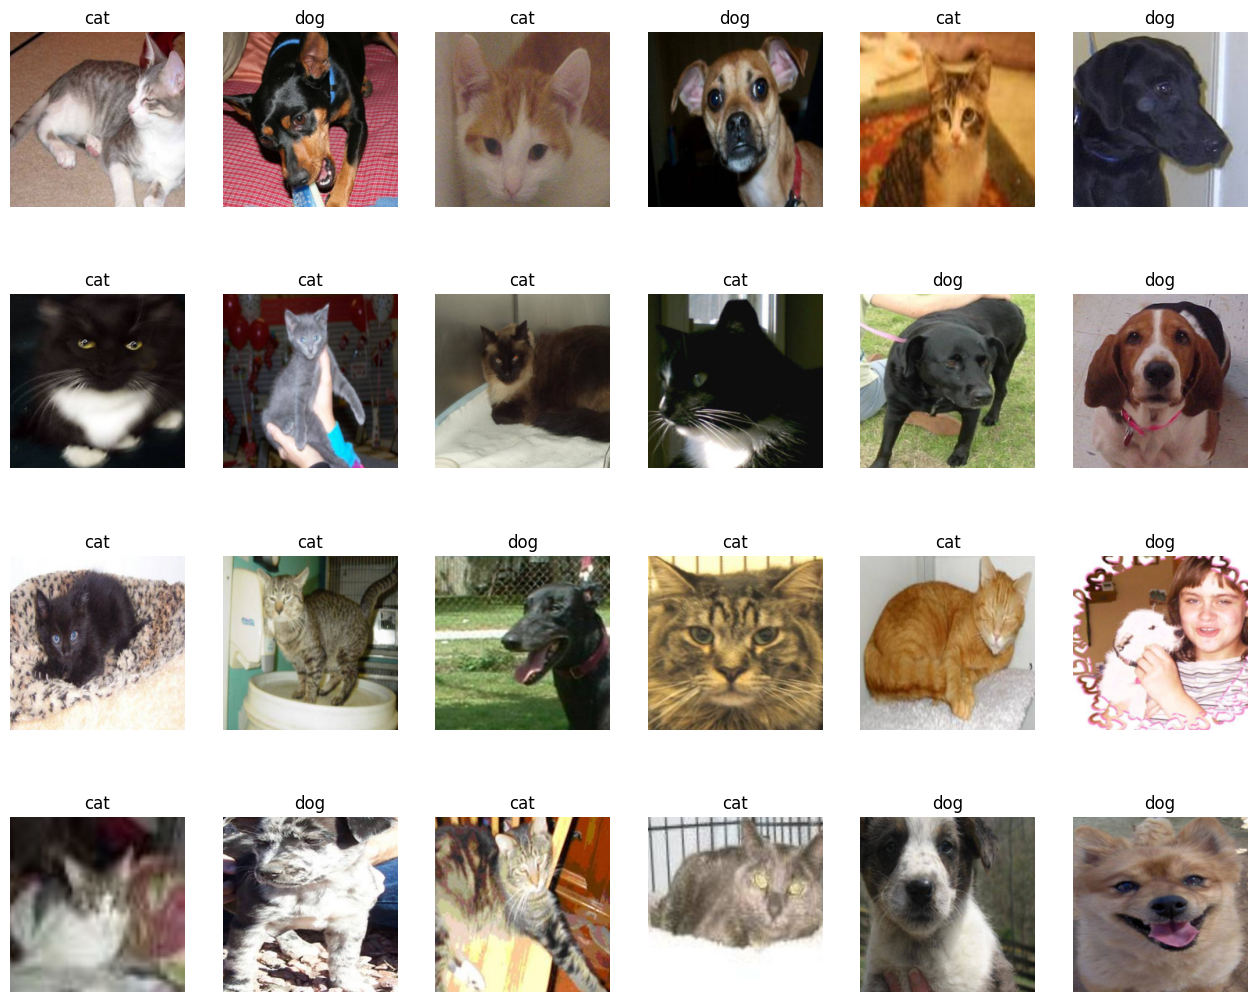

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# train_loader로부터 데이터 가져오기
samples, labels = next(iter(train_loader))

# 클래스 정의
classes = {0: 'cat', 1: 'dog'}

# 이미지 출력
fig = plt.figure(figsize=(16, 24))
for i in range(24):
    ax = fig.add_subplot(4, 6, i + 1)
    ax.set_title(classes[labels[i].item()])
    ax.axis('off')
    ax.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0.5)
plt.show()


## ResNet Model Load 및 Prediction layer 수정

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = torchvision.models.resnet50(pretrained=True)
model

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

In [ ]:
from torchsummary import summary

model.cuda()
summary(model, input_size=(3,224,224))

## 훈련

In [ ]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()

    train_loss = 0
    train_acc = 0
    train_correct = 0

    train_losses = []     # train loss 값을 저장할 리스트
    train_accuracies = [] # train accuracy를 저장할 리스트
    valid_losses = []     # valid loss 값을 저장할 리스트
    valid_accuracies = [] # valid accuracy를 저장할 리스트

    for epoch in range(epochs):
        start = time.time()

        # train
        for train_x, train_y in train_loader:
            model.train() # 모델을 학습 모드로 설정
            train_x, train_y = train_x.to(device), train_y.to(device).float() # 데이터, 라벨을 GPU로 이동
            optimizer.zero_grad()           # 새로운 배치의 기울기를 계산하기 전에 이전 기울기 삭제
            pred = model(train_x)
            loss = criterion(pred, train_y) # 예측된 출력 (pred)과 실제 정답 레이블 (train_y) 사이의 손실을 계산
            loss.backward()                 # 역전파 : "오차"를 계산하여 가중치를 수정
            optimizer.step()                # 모델의 파라미터를 업데이트
                                            # 모델의 가중치를 조정하여 현재 학습 데이터에 대한 손실을 최소화하는 방향으로 진행

            train_loss += loss.item()

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()

        # validation
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval() # 모델을 평가 모드로 설정
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float() # 데이터, 라벨을 GPU로 이동
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()

        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)

        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')

        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)

        train_loss = 0
        train_acc = 0
        train_correct = 0

    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()

    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

323.227sec : [Epoch 1/2] -> train loss: 0.0338, train acc: 98.810% / valid loss: 0.0268, valid acc: 99.160%
327.276sec : [Epoch 2/2] -> train loss: 0.0159, train acc: 99.470% / valid loss: 0.0225, valid acc: 99.160%


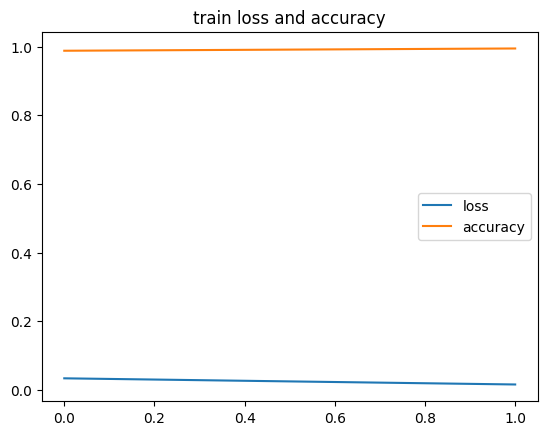

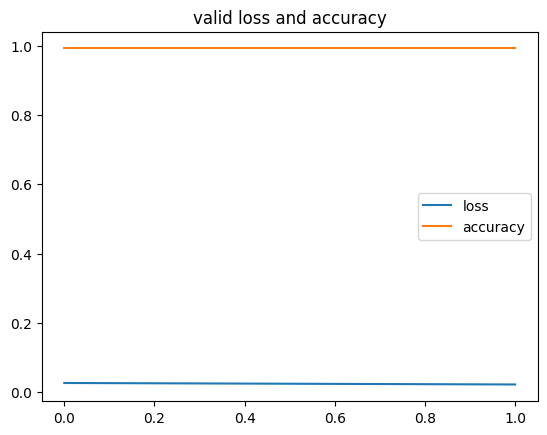

In [ ]:
# Loss Function
criterion = nn.BCELoss() # Binary Class Entropy Loss

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

fit(model, criterion, optimizer, 2, train_loader, valid_loader)

In [ ]:
save_path = "/content/drive/MyDrive/02.Project/Bit_PoscoDX/Model/"

torch.save(model, save_path + 'cat_dog_model.pt')  # 전체 모델 저장
torch.save(model.state_dict(), save_path + 'cat_dog_model_state_dict.pt')  # 모델 객체의 state_dict 저장

## 모델 평가

In [ ]:
def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0

            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')

eval(model, criterion, test_loader)

eval loss: 0.0219, eval acc: 99.200%


## 결과 확인

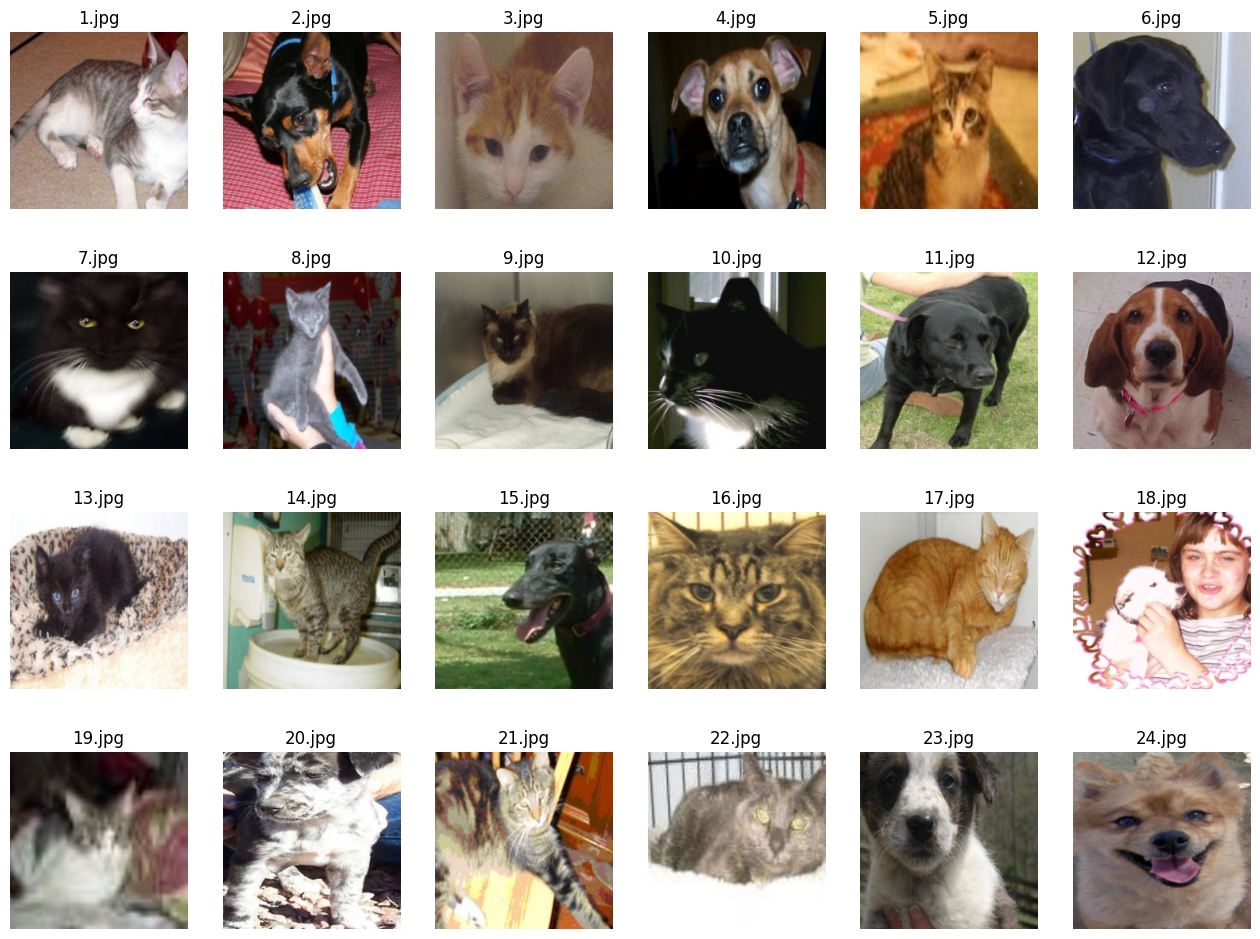

In [ ]:
# 결과
test_dir = "/content/drive/MyDrive/02.Project/Bit_PoscoDX/Data/test1"
submit_files = [f'{i}.jpg' for i in range(1, 12500+1)]
submit_dataset = CustomDataset(submit_files, test_dir, mode='test', transform=test_transform)
submit_loader = torch.utils.data.DataLoader(submit_dataset, batch_size=32, shuffle=False)

imgs, files = next(iter(submit_loader))
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(files[i])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


In [ ]:
def predict(model, data_loader):
    with torch.no_grad():
        model.eval()
        ret = None
        for img, files in data_loader:
            # print(img)
            # print(files)
            img = img.to(device)
            pred = model(img)

            if ret is None:
                ret = pred.cpu().numpy()
            else:
                ret = np.vstack([ret, pred.cpu().numpy()])
    return ret

pred = predict(model, submit_loader)

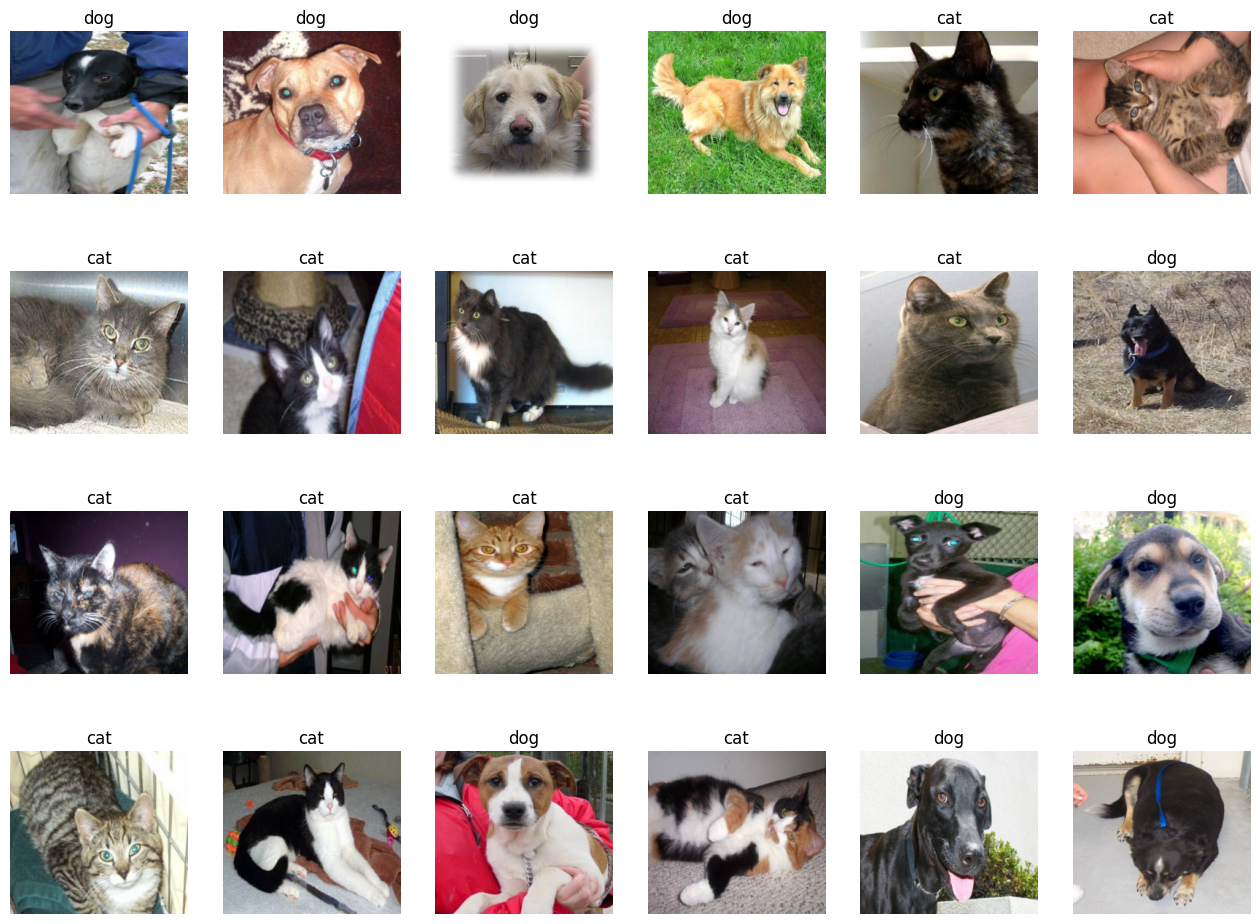

In [ ]:
sample_pred = pred[:24]
sample_pred[sample_pred >= 0.5] = 1
sample_pred[sample_pred < 0.5] = 0

imgs, files = next(iter(submit_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[sample_pred[i][0]])
    a.axis('off')
    a.imshow(np.transpose(imgs[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

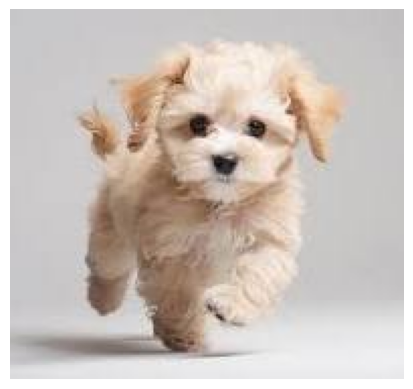

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_dir = "/content/drive/MyDrive/02.Project/Bit_PoscoDX/test_image/"
test_img = test_dir + 'dog_test.jpg' # cat_test

img = mpimg.imread(test_img)
plt.imshow(img)
plt.axis('off')  # Hide axis ticks and labels
plt.show()

## model load

In [ ]:
model_path = "/content/drive/MyDrive/02.Project/Bit_PoscoDX/Model/"

[[9.965734e-07]]


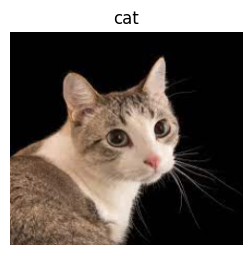

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load(model_path + "cat_dog_model.pt", map_location=device)
# print(model)

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])

test_dir = "/content/drive/MyDrive/02.Project/Bit_PoscoDX/test_image/"
test_img = test_dir + 'cat_test.jpg'  # cat_test
img = Image.open(test_img)
img  = test_transform(img)

def my_predict(model, img, device):
    with torch.no_grad():
        model.eval()
        img = img.unsqueeze(0)
        img = img.to(device)
        pred = model(img)
        return pred.cpu().numpy()

pred = my_predict(model, img, device)
print(pred)

sample_pred = pred
sample_pred[sample_pred >= 0.5] = 1
sample_pred[sample_pred < 0.5] = 0

classes = {0: 'cat', 1: 'dog'}
fig = plt.figure(figsize=(3, 3))
a = fig.add_subplot(1, 1, 1)
a.set_title(classes[sample_pred[0][0]])
a.axis('off')

# 이미지를 시각화할 때 축의 형태를 (1, 2, 0)으로 지정
a.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
plt.show()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import json

with open('/content/drive/MyDrive/02.Project/Bit_PoscoDX/class_index.json', 'r') as f:
    class_idx = json.load(f)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load(model_path + "cat_dog_model.pt", map_location=device)
# print(model)

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])

test_dir = "/content/drive/MyDrive/02.Project/Bit_PoscoDX/test_image/"
test_img = test_dir + 'dog_test.jpg'  # cat_test
img = Image.open(test_img)
img  = test_transform(img)

with torch.no_grad():
    model.eval()
    img = img.unsqueeze(0)
    img = img.to(device)
    pred = model(img)

print(pred.cpu().numpy()[0][0])
if pred[0] >= 0.5:
  predicted_class_idx = 1
else:
  predicted_class_idx = 0

print(predicted_class_idx, str(predicted_class_idx))
predicted_class = class_idx[str(predicted_class_idx)]
print('c' + predicted_class)
confidence = pred[predicted_class_idx]
print(confidence)


# sample_pred = pred
# sample_pred[sample_pred >= 0.5] = 1
# sample_pred[sample_pred < 0.5] = 0

# classes = {0: 'cat', 1: 'dog'}
# fig = plt.figure(figsize=(3, 3))
# a = fig.add_subplot(1, 1, 1)
# a.set_title(classes[sample_pred[0][0]])
# a.axis('off')

# # 이미지를 시각화할 때 축의 형태를 (1, 2, 0)으로 지정
# a.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
# plt.show()